In [2]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

In [3]:
# Downloading and Loading Dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
 
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [98]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        input_tensor = input_tensor.to(device)
        h_cur = h_cur.to(device)


        concat_input_hcur = torch.cat([input_tensor, h_cur], dim=1) 
        concat_input_hcur = concat_input_hcur.to(device)

        concat_input_hcur_conv = self.conv(concat_input_hcur)
        concat_input_hcur_conv = concat_input_hcur_conv.to(device)

        cc_input_gate, cc_forget_gate, cc_output_gate, cc_output = torch.split(concat_input_hcur_conv, self.hidden_dim, dim=1)
        input_gate = torch.sigmoid(cc_input_gate)
        forget_gate = torch.sigmoid(cc_forget_gate)
        output_gate = torch.sigmoid(cc_output_gate)
        output = torch.tanh(cc_output)

        c_next = forget_gate * c_cur + input_gate * output
        h_next = output * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

  

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
       
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        classifier_in_dim= (self.hidden_dim[0]*image_size[0]*image_size[1])
        classifier_output_dim = output_label_size
        self.classifier = nn.Linear(classifier_in_dim, classifier_output_dim)

        conv_lstms  = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            conv_lstms.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.conv_lstms = nn.ModuleList(conv_lstms)

    def forward(self, input_tensor, hidden_state=None):
       

        
        b, _, _, h, w = input_tensor.size()

        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for i in range(self.num_layers):

            h, c = hidden_state[i]
            output_inner = []
            for t in range(seq_len):
                h, c = self.conv_lstms[i](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            output_list = output_list[-1:]
            last_state_list = last_state_list[-1:]
        batch_shape = output_list[-1].shape[0]

        final_out= self.classifier(output_list[-1].view(batch_shape, - 1))

        return final_out

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.conv_lstms[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [100]:
convmodel= ConvLSTM(1,64,(5,5),1)
if torch.cuda.is_available():
    convmodel.to(device)

In [101]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images=images.unsqueeze(dim=1)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass only to get logits/output
        outputs = model(images)
        outputs = outputs.to(device)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images=images.unsqueeze(dim=1)
        images = images.to(device)
        
        labels = labels.to(device)
        
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    epochs = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        epochs.append(epoch+1)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, epochs


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [102]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(convmodel.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [103]:
train_loss_conv, val_loss_conv, loss_iters_conv, valid_acc_conv, epochs_conv = train_model(
        model=convmodel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.49786. : 100%|██████████| 235/235 [00:34<00:00,  6.84it/s]


Epoch 1/20
    Train loss: 0.892
    Valid loss: 2.30258
    Accuracy: 9.950000000000001%




Epoch 2 Iter 235: loss 0.43131. : 100%|██████████| 235/235 [00:34<00:00,  6.83it/s]


Epoch 2/20
    Train loss: 0.50237
    Valid loss: 0.56001
    Accuracy: 81.06%




Epoch 3 Iter 235: loss 0.44263. : 100%|██████████| 235/235 [00:34<00:00,  6.88it/s]


Epoch 3/20
    Train loss: 0.44562
    Valid loss: 0.48106
    Accuracy: 83.45%




Epoch 4 Iter 235: loss 0.33508. : 100%|██████████| 235/235 [00:34<00:00,  6.83it/s]


Epoch 4/20
    Train loss: 0.41536
    Valid loss: 0.45372
    Accuracy: 84.3%




Epoch 5 Iter 235: loss 0.55420. : 100%|██████████| 235/235 [00:34<00:00,  6.81it/s]


Epoch 5/20
    Train loss: 0.39118
    Valid loss: 0.42909
    Accuracy: 84.92%




Epoch 6 Iter 235: loss 0.61059. : 100%|██████████| 235/235 [00:34<00:00,  6.81it/s]


Epoch 6/20
    Train loss: 0.37071
    Valid loss: 0.40674
    Accuracy: 85.82%




Epoch 7 Iter 235: loss 0.33388. : 100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Epoch 7/20
    Train loss: 0.36621
    Valid loss: 0.39814
    Accuracy: 86.03%




Epoch 8 Iter 235: loss 0.43416. : 100%|██████████| 235/235 [00:34<00:00,  6.81it/s]


Epoch 8/20
    Train loss: 0.36286
    Valid loss: 0.39358
    Accuracy: 86.1%




Epoch 9 Iter 235: loss 0.27886. : 100%|██████████| 235/235 [00:34<00:00,  6.80it/s]


Epoch 9/20
    Train loss: 0.35889
    Valid loss: 0.39356
    Accuracy: 86.04%




Epoch 10 Iter 235: loss 0.35011. : 100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Epoch 10/20
    Train loss: 0.35577
    Valid loss: 0.38879
    Accuracy: 86.33%




Epoch 11 Iter 235: loss 0.37647. : 100%|██████████| 235/235 [00:34<00:00,  6.80it/s]


Epoch 11/20
    Train loss: 0.35206
    Valid loss: 0.38873
    Accuracy: 86.2%




Epoch 12 Iter 235: loss 0.21483. : 100%|██████████| 235/235 [00:34<00:00,  6.80it/s]


Epoch 12/20
    Train loss: 0.35054
    Valid loss: 0.38299
    Accuracy: 86.36%




Epoch 13 Iter 235: loss 0.44921. : 100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Epoch 13/20
    Train loss: 0.35046
    Valid loss: 0.38257
    Accuracy: 86.33%




Epoch 14 Iter 235: loss 0.32753. : 100%|██████████| 235/235 [00:34<00:00,  6.78it/s]


Epoch 14/20
    Train loss: 0.34938
    Valid loss: 0.38175
    Accuracy: 86.41%




Epoch 15 Iter 235: loss 0.32910. : 100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Epoch 15/20
    Train loss: 0.34882
    Valid loss: 0.38198
    Accuracy: 86.28%




Epoch 16 Iter 235: loss 0.23716. : 100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Epoch 16/20
    Train loss: 0.3476
    Valid loss: 0.38094
    Accuracy: 86.42999999999999%




Epoch 17 Iter 235: loss 0.40060. : 100%|██████████| 235/235 [00:34<00:00,  6.77it/s]


Epoch 17/20
    Train loss: 0.34783
    Valid loss: 0.38051
    Accuracy: 86.41%




Epoch 18 Iter 235: loss 0.21770. : 100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Epoch 18/20
    Train loss: 0.34724
    Valid loss: 0.3803
    Accuracy: 86.42999999999999%




Epoch 19 Iter 235: loss 0.37007. : 100%|██████████| 235/235 [00:34<00:00,  6.78it/s]


Epoch 19/20
    Train loss: 0.34753
    Valid loss: 0.38016
    Accuracy: 86.42%




Epoch 20 Iter 235: loss 0.31633. : 100%|██████████| 235/235 [00:34<00:00,  6.80it/s]

Epoch 20/20
    Train loss: 0.34719
    Valid loss: 0.38002
    Accuracy: 86.42999999999999%


Training completed


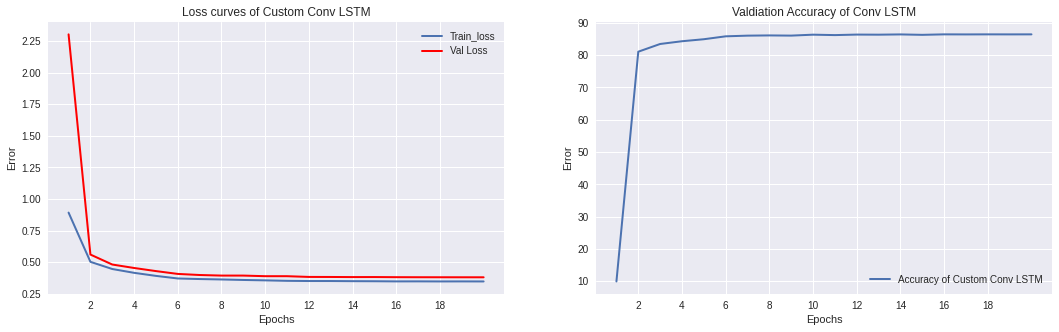

In [107]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(epochs_conv, train_loss_conv, label="Train_loss", linewidth=2)
ax[0].plot(epochs_conv, val_loss_conv, label="Val Loss", c='red', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Loss curves of Custom Conv LSTM")

ax[1].plot(epochs_conv, valid_acc_conv, linewidth=2,label="Accuracy of Custom Conv LSTM")

ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Valdiation Accuracy of Conv LSTM")


plt.show()